### Human pose classification

In [1]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# cd /content/drive/MyDrive/AI-2025-study

In [3]:
cd /content/drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
!pip install -q datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 9.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-nvrtc-cu12==12

In [6]:
from datasets import Dataset, load_dataset

dataset = load_dataset("Bingsu/Human_Action_Recognition", split='train')

README.md:   0%|          | 0.00/4.70k [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/229M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/98.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/12600 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5400 [00:00<?, ? examples/s]

In [7]:
dataset = dataset.train_test_split(test_size=0.2)

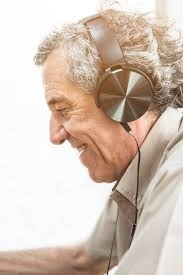

In [8]:
dataset['train'][6]['image']

In [9]:
labels = dataset['train'].features['labels'].names

In [10]:
id2labels = dict()
labels2id = dict()

for idx, label in enumerate(labels):
  id2labels[idx] = label
  labels2id[label] = idx

In [11]:
print(id2labels)
print(labels2id)

{0: 'calling', 1: 'clapping', 2: 'cycling', 3: 'dancing', 4: 'drinking', 5: 'eating', 6: 'fighting', 7: 'hugging', 8: 'laughing', 9: 'listening_to_music', 10: 'running', 11: 'sitting', 12: 'sleeping', 13: 'texting', 14: 'using_laptop'}
{'calling': 0, 'clapping': 1, 'cycling': 2, 'dancing': 3, 'drinking': 4, 'eating': 5, 'fighting': 6, 'hugging': 7, 'laughing': 8, 'listening_to_music': 9, 'running': 10, 'sitting': 11, 'sleeping': 12, 'texting': 13, 'using_laptop': 14}


### image preprocessing

In [12]:
from transformers import AutoImageProcessor

# image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [13]:
model_ckpt = "google/vit-base-patch16-224-in21k"

In [14]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

In [15]:
image_processor = AutoImageProcessor.from_pretrained(model_ckpt)
normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)

size = (image_processor.size['shortest_edge'] if 'shortest_edge' in image_processor.size else (image_processor.size['height'], image_processor.size['width']))

_transforms = Compose(
    [
        RandomResizedCrop(size),
        # RandomHorizontalFlip(),
        ToTensor(),
        normalize,
    ]
)

def transforms(batch):
  batch["pixel_values"] = [_transforms(image.convert("RGB")) for image in batch["image"]]
  del batch["image"]
  return batch


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


In [16]:
dataset = dataset.with_transform(transforms)

### Model evaluation
https://huggingface.co/docs/transformers/en/tasks/sequence_classification#evaluate

In [17]:
!pip install -q evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.1 MB/s eta 0:00:00


In [18]:
import evaluate
import numpy as np

In [19]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

### ViT fine-tuning

In [20]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer
import torch

In [21]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model = AutoModelForImageClassification.from_pretrained(
    model_ckpt,
    num_labels=len(labels),
    id2label=id2labels,
    label2id=labels2id,
).to(device)
#

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
len(labels)

15

### Model training

In [23]:
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    output_dir="vit-base-pose-classification",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    compute_metrics=compute_metrics,
    tokenizer=image_processor,
)


In [24]:
trainer.train()


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: bdanhcse-work (bdanhcse-work-ho-chi-minh-university-of-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch,Training Loss,Validation Loss,Accuracy
1,1.568500,0.988174,0.746429
2,0.898200,0.846728,0.763889


Epoch,Training Loss,Validation Loss,Accuracy
1,1.568500,0.988174,0.746429
2,0.898200,0.846728,0.763889
3,0.735800,0.746065,0.788095
4,0.582300,0.738723,0.782540
5,0.518800,0.707183,0.791667


TrainOutput(global_step=3150, training_loss=0.8123257785373263, metrics={'train_runtime': 2117.62, 'train_samples_per_second': 23.8, 'train_steps_per_second': 1.488, 'total_flos': 3.906051336688435e+18, 'train_loss': 0.8123257785373263, 'epoch': 5.0})

In [25]:
trainer.evaluate()

{'eval_loss': 0.7015760540962219,
 'eval_accuracy': 0.7992063492063493,
 'eval_runtime': 35.8636,
 'eval_samples_per_second': 70.266,
 'eval_steps_per_second': 4.406,
 'epoch': 5.0}

In [26]:
trainer.save_model('vit-human-pose-classification')

### Confusion matrix and graph

In [27]:
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [30]:
logits = trainer.predict(dataset["test"])
logits = logits.predictions
y_pred = np.argmax(logits, axis=1)
y_true = [x['labels'] for x in dataset['test']]
print(classification_report(y_true, y_pred, target_names=labels))

                    precision    recall  f1-score   support

           calling       0.77      0.61      0.68       163
          clapping       0.85      0.77      0.81       191
           cycling       0.94      0.89      0.91       168
           dancing       0.77      0.79      0.78       154
          drinking       0.78      0.79      0.78       181
            eating       0.88      0.86      0.87       183
          fighting       0.77      0.84      0.80       153
           hugging       0.81      0.83      0.82       181
          laughing       0.81      0.83      0.82       157
listening_to_music       0.75      0.72      0.73       167
           running       0.81      0.83      0.82       156
           sitting       0.61      0.70      0.65       159
          sleeping       0.90      0.86      0.88       181
           texting       0.58      0.64      0.61       155
      using_laptop       0.76      0.76      0.76       171

          accuracy                    

<Axes: >

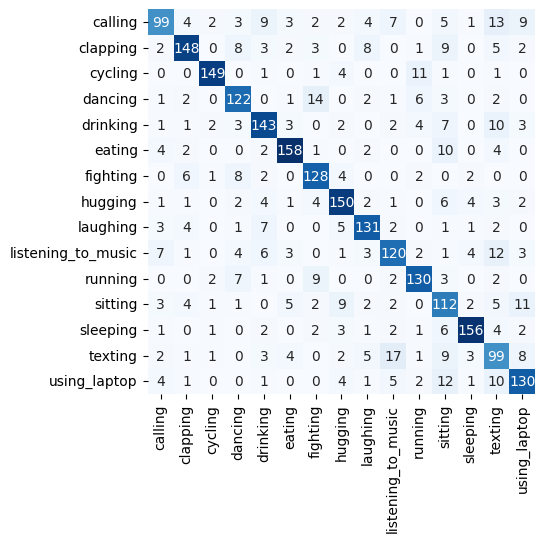

In [35]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, xticklabels=labels2id.keys(), yticklabels=labels2id.keys(), annot=True, fmt='d', cmap='Blues', cbar=False)

### Predict on real image

In [41]:
from transformers import pipeline

classifier = pipeline(
    "image-classification",
    model='vit-human-pose-classification',
    image_processor=image_processor
)

url = 'test.jpg'
output = classifier(url)
(output)

Device set to use cuda:0


[{'label': 'dancing', 'score': 0.9764495491981506},
 {'label': 'clapping', 'score': 0.9596065282821655},
 {'label': 'running', 'score': 0.6996004581451416},
 {'label': 'fighting', 'score': 0.5643048882484436},
 {'label': 'sitting', 'score': 0.4468378722667694}]